# Import Libraries

In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# for reading and displaying images
from skimage import io
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# PyTorch libraries and modules
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import Linear, ReLU, Tanh, Hardtanh, LeakyReLU, ELU, Sigmoid, CrossEntropyLoss, Sequential, Conv2d, ConvTranspose2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn.functional as f

In [2]:
data = os.uname()
global device
if data[1] == 'lambda-dual':
    device = 'cuda:1'
    print('The model will be trained on {}'.format(device))
    data_dir = '/home/arya1080/python_projects/temp_flim_data/'
    save_dir = '/home/arya1080/engrprojects/WilsonGroup/MRA_grant/work_in_progress_arya/spectral_autoencoder_data/'
    print('Data will be loaded from "{}"'.format(data_dir))
    print('Data will be saved to "{}"'.format(save_dir))
# elif data[1] == 'linuxg3' or data[1] == 'linuxg4':
#     device = 'cuda:0'
#     data_dir = '/top/projects/WilsonGroup/TuCo/data/20210920 modify SVD_mods_Arya/620nm/'
#     save_dir = '/top/projects/WilsonGroup/MRA_grant/work_in_progress_arya/spectral_autoencoder_data/'
#     print('The model will be trained on {}'.format(device))
#     print('Data will be saved to "{}"'.format(save_dir))
    

The model will be trained on cuda:1
Data will be loaded from "/home/arya1080/python_projects/temp_flim_data/"
Data will be saved to "/home/arya1080/engrprojects/WilsonGroup/MRA_grant/work_in_progress_arya/spectral_autoencoder_data/"


# Load dataset

In [3]:
# loading dataset
filenames = os.listdir(data_dir)
print(filenames)
img_stack = []
for files in filenames:
    if files.endswith(".tif"):
        img = io.imread(data_dir + files)
        img_stack.append(img)

# convert images to numpy arrays
img_stack = np.asarray(img_stack)
img_stack = img_stack.astype('float32')
img_stack = np.swapaxes(img_stack, 3,1)
# img_stack = img_stack[:,:,:,35:60]
# get image height and width metrics
_, nx, ny, nch = img_stack.shape
print('Input dataset specs:')
print('img width = {}, img height = {}, img channels = {}'.format(nx, ny, nch))

# process the input image stack
img_stack = torch.tensor(img_stack)
img_stack = img_stack.to(device)

['HER23_D_FLIM.tif']
Input dataset specs:
img width = 256, img height = 256, img channels = 256


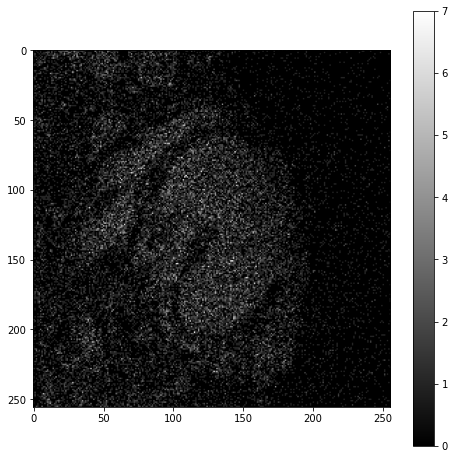

In [4]:
plt.figure(figsize=(8,8))
plt.imshow(img_stack[0,:,:,70].detach().cpu().numpy(), cmap='gray')
plt.colorbar()
plt.show()

# Define functions

In [21]:
class ResnetBlock(Module):
    def __init__(self, channels, kernel_size, stride, padding):
        super(ResnetBlock, self).__init__()
        self.conv = Sequential(
                        Conv2d(in_channels=channels, 
                          out_channels=channels,
                          kernel_size=kernel_size,
                          stride=stride,
                          padding=padding, bias=False) )
        
    def forward(self, x):
        intermediate = self.conv(x)
        out = x + intermediate
        return out
        

class ScalableSat(Module):
    def __init__(self):
        super(ScalableSat, self).__init__()
 
        self.a = nn.parameter.Parameter(torch.Tensor([1.0,1.0,0.0]))
        self.tanh = Hardtanh()
        
    def forward(self,x):
        return self.a[1]*self.tanh(self.a[0]*x)+self.a[2]
    
class ScaleAndOffset(Module):
    def __init__(self):
        super(ScaleAndOffset, self).__init__()
 
        self.a = nn.parameter.Parameter(torch.Tensor([10.0,0.0]))
        
    def forward(self,x):
        return x * self.a[0] + self.a[1]
    
class LeakyHardsigmoid(Module):
    def __init__(self, negative_slope=0.1):
        super(LeakyHardsigmoid,self).__init__()
        self.ns = negative_slope
        
    def forward(self,x):
        return f.leaky_relu(-f.leaky_relu(-(x-3)/6,negative_slope=self.ns)+1,negative_slope=self.ns)

class OffsetHardsigmoid(Module):
    def __init__(self):
        super(OffsetHardsigmoid,self).__init__()
        
        
    def forward(self,x):
        return f.hardsigmoid(x-3)

class OffsetLeakyHardsigmoid(Module):
    def __init__(self):
        super(OffsetLeakyHardsigmoid,self).__init__()
        
        
    def forward(self,x):
        return f.rrelu(-f.rrelu(-(x-1),lower=0)+1,lower=0)
    
class AbsActivation(Module):
    def __init__(self):
        super(AbsActivation,self).__init__()
        
    def forward(self,x):
        return torch.abs(x)

class NormalizeEndmembers(Module):
    def forward(self,X):
        return X / X.norm(dim=0)
            
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(nch, 64, kernel_size=3, stride=1, padding=1,bias=False),
            
            # Defining additional 2D convolution layer
            Conv2d(64, nch_bottleneck, kernel_size=1, stride=1, padding=0, bias=False),
            
            # implementing the v-notch nonlinearity
            nn.Hardtanh(),
            AbsActivation()
        )
        
        self.cnn_spectral_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(nch_bottleneck, nch, kernel_size=1, stride=1,bias=False),  
            ScaleAndOffset()
        )
       
        self.t = torch.linspace(0,10,256).to(device)
        self.t = self.t[:,None]
        self.t0 = nn.parameter.Parameter(torch.Tensor([2]))
        self.sigma = nn.parameter.Parameter(torch.Tensor([0.1]))
        self.tau= nn.parameter.Parameter(torch.Tensor([0.5, 2, 5])[None,:])
        self.a = nn.parameter.Parameter(torch.Tensor([1.0]))        
        
    def getTau(self):
        return torch.abs(self.tau)
    
    def getSOEMlayer(self):
        return self.cnn_spectral_layers[0]
    
    # Defining the forward pass    
    def forward(self, x):
        z = self.cnn_layers(x)
        y = self.cnn_spectral_layers(z)
        return y
    
    def forward_enc(self, x):
        z = self.cnn_layers(x)
        return z
    
    def forward_dec(self, z):
        tt = self.t - self.t0
        tau = self.getTau()
        x = torch.exp(-(tt - self.sigma**2/(2*tau))/(tau+1e-3)) * torch.erfc(-(tt - self.sigma**2/(tau+1e-3))/(np.sqrt(2)*(self.sigma+1e-3)))
        self.endmembers = x
        y = f.conv2d(z, x[:,:,None, None]) * self.a
        return y

# define latent space visualization function
def visualize_z(ind):
    data = img_stack[ind,:,:,:]
    data = data[None,:]
    data = data.to(device)
    out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
    out = out[0,:,:,:]
    out = torch.permute(out, (1,2,0))
    img = out.detach().cpu().numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(1.2*img[:,:,0:3])
    plt.show()
    return img

# define latent space visualization function
def generate_z_image(ind, indices):
    data = img_stack[ind,:,:,:]
    data = data[None,:]
    data = data.to(device)
    out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
    out = out[0,indices[0:3],:,:]
    out = torch.permute(out, (1,2,0))
    img = out.detach().cpu().numpy()
    return 1.*img

def visualSummary(L1_loss, indices):
    plt.figure(figsize=(12,6))
    plt.subplot(1,3,1)
    img = generate_z_image(0, indices)
    plt.imshow(img)
    plt.colorbar()
    plt.subplot(1,3,2)
    w = model.endmembers
    w = w.detach().cpu().numpy().squeeze()
    plt.plot(w[:,indices[0]],'r')
    plt.plot(w[:,indices[1]],'g')
    plt.plot(w[:,indices[2]],'b')
    plt.title('recovered endmembers')
    plt.xlabel('samples')
    plt.subplot(1,3,3)
    plt.plot(L1_loss)
    plt.title('Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('L1 Loss')
    plt.tight_layout()
    plt.show()
    
# Custom Loss Functions
def meansq(x):
    return torch.mean((x-torch.mean(x))**2)

def corr(x,y):
    return torch.sum(x*y) / (torch.sqrt(torch.sum(x**2))*torch.sqrt(torch.sum(y**2)))

def VariationOfEndmembers(weights,padding=False):
    weightsPadded = weights
    if padding:
        weightsPadded = f.pad(weights,[0,0,0,0,0,0,1,1])
    deriv = weightsPadded[1:,]-weightsPadded[:-1,]
    V = torch.sum(torch.abs(deriv))
    return V

def VariationOfStack(stack):
    grad_tau = stack - torch.roll(stack,1,(0,1,0,0))
    grad_x = stack - torch.roll(stack,1,(0,0,1,0))
    grad_y = stack - torch.roll(stack,1,(0,0,0,1))
    
    V = torch.sum(torch.sqrt(grad_tau**2 + grad_x**2 + grad_x**2))
    return V

# model training routine definition
def train_model(model, n_epochs, img_stack, lr):
    
    # define loss function
    criterion = nn.L1Loss()
    
    # define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr)
    
    # initialize model weights and send to train device
    model.to(device) # load the model in the training device
    
    # define variables
    L1_loss = []
        
    # iterate over the epochs
    for epoch in tqdm(range(1, n_epochs+1)):
        # monitor training loss
        train_loss = 0.0

        # keep track of meansq value for each channel
        channelmsq = torch.zeros(nch_bottleneck).to(device)

        #Training
        for images in img_stack:
            images = images[None, :]
            image_x_p = torch.permute(images, (0, 3, 1, 2))
            image_x_p = image_x_p.to(device)
            optimizer.zero_grad()   
            z = model.forward_enc(image_x_p)
            outputs = model.forward_dec(z)

            # reconstruction loss
            loss_recon = criterion(outputs, image_x_p)
            
            # variance-ordering
            channelmsq += torch.mean(z**2,dim=[2,3]).squeeze()
            
            # interchannel correlation loss
            zvec = z.squeeze().view(nch_bottleneck,-1)
            zvec = zvec-torch.mean(zvec,1,keepdim=True)
            zcov = torch.matmul(zvec,zvec.transpose(0,1))
            zstds = torch.sqrt(zcov.diag()).expand(1,-1)
            zstdprods = torch.matmul(zstds.transpose(0,1),zstds)
            zcorrabs = zcov / (zstdprods + 1e-6)
            loss_zcorr = (torch.sum(f.relu(zcorrabs.triu())) - zcorrabs.trace())

            # endmember variation loss
#             w = model.getSOEMlayer().weight
#             loss_V_endmembers = VariationOfEndmembers(w,padding=True)
            
            # stack total variation loss
#             loss_V_outputStack = VariationOfStack(outputs)
            
            # total loss
            loss = loss_recon 

            loss.backward()
            optimizer.step()
            train_loss += loss.item()*image_x_p.size(0)

        train_loss = train_loss/len(img_stack)
        L1_loss.append(train_loss)

        # rearrange channels so red has max variance, blue the least
        indices = channelmsq.argsort(descending=True)

        if epoch%50 == 0:
            visualSummary(L1_loss, indices)
        
    return L1_loss

# Train model

Starting training of models on cuda:1


  2%|▊                                       | 40/2000 [00:00<00:10, 195.56it/s]

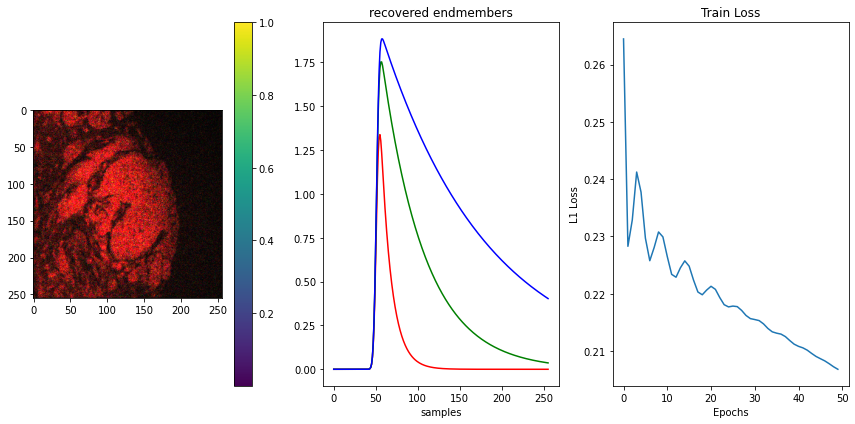

  4%|█▌                                      | 81/2000 [00:00<00:16, 119.11it/s]

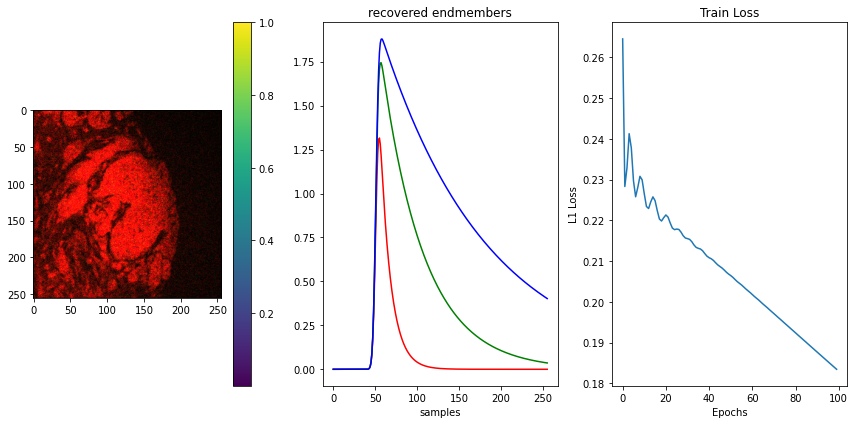

  7%|██▊                                    | 142/2000 [00:01<00:15, 118.72it/s]

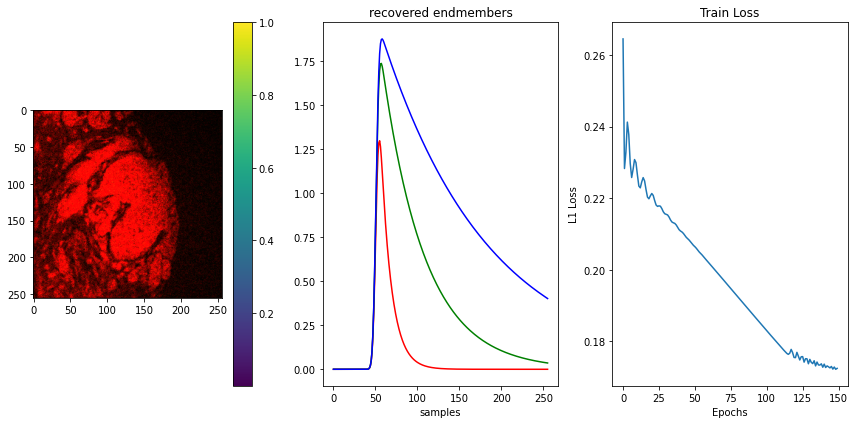

  9%|███▌                                   | 180/2000 [00:01<00:17, 106.05it/s]

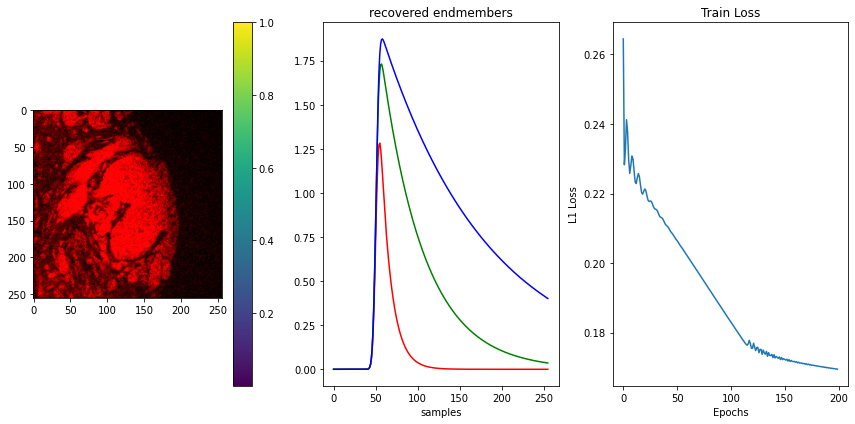

 12%|████▋                                  | 242/2000 [00:02<00:14, 121.76it/s]

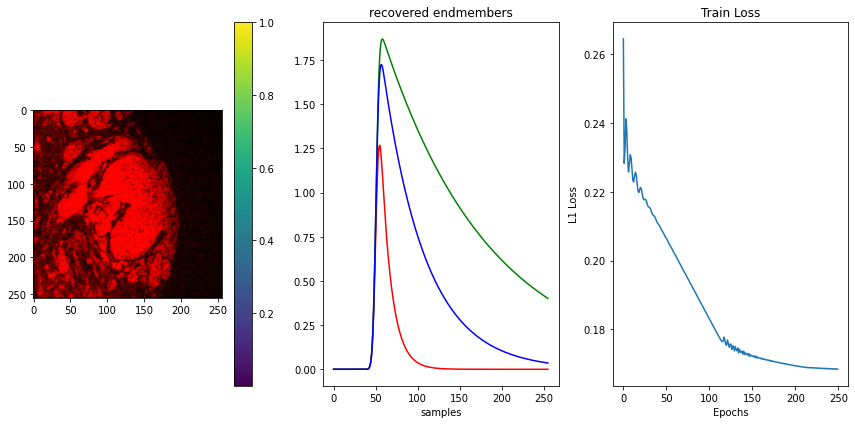

 14%|█████▍                                 | 280/2000 [00:02<00:15, 108.23it/s]

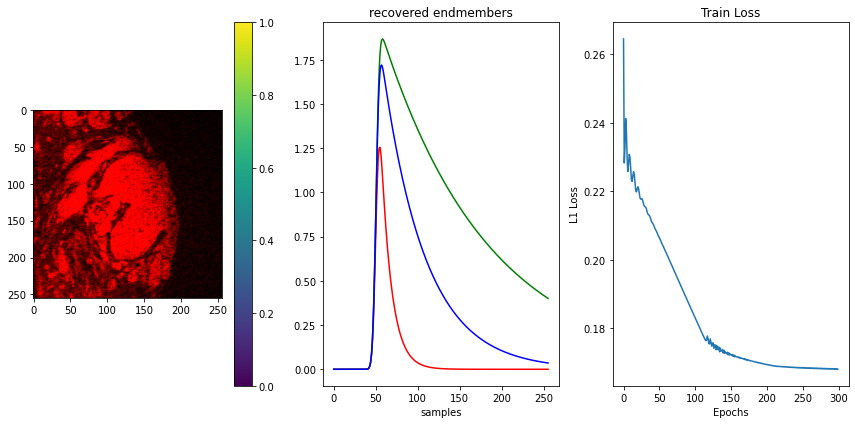

 17%|██████▋                                | 342/2000 [00:03<00:13, 122.00it/s]

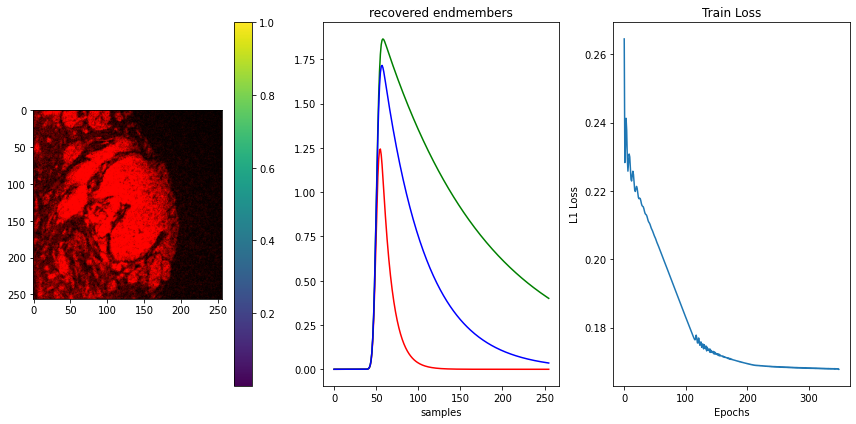

 19%|███████▍                               | 380/2000 [00:03<00:16, 100.80it/s]

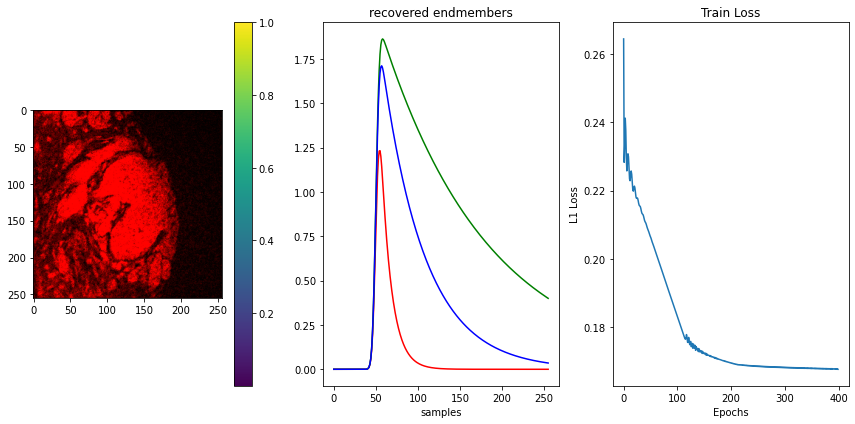

 22%|████████▌                              | 442/2000 [00:04<00:13, 118.99it/s]

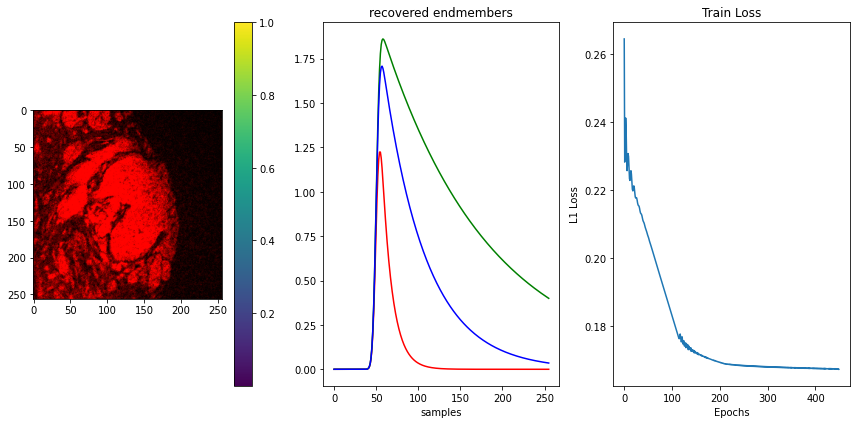

 24%|█████████▎                             | 480/2000 [00:04<00:14, 107.04it/s]

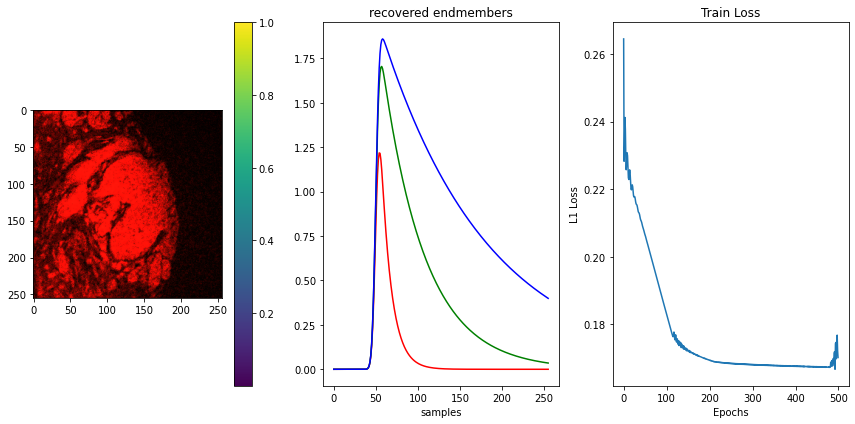

 27%|██████████▌                            | 542/2000 [00:05<00:12, 121.38it/s]

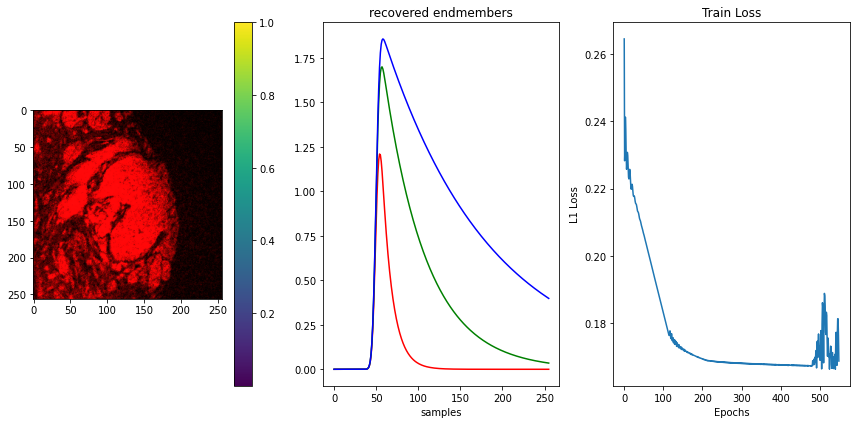

 29%|███████████▎                           | 580/2000 [00:05<00:13, 107.93it/s]

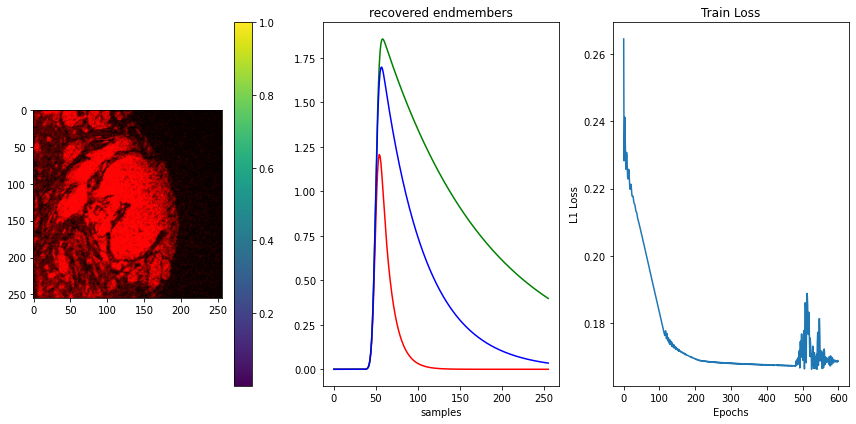

 32%|████████████▌                          | 642/2000 [00:06<00:11, 122.11it/s]

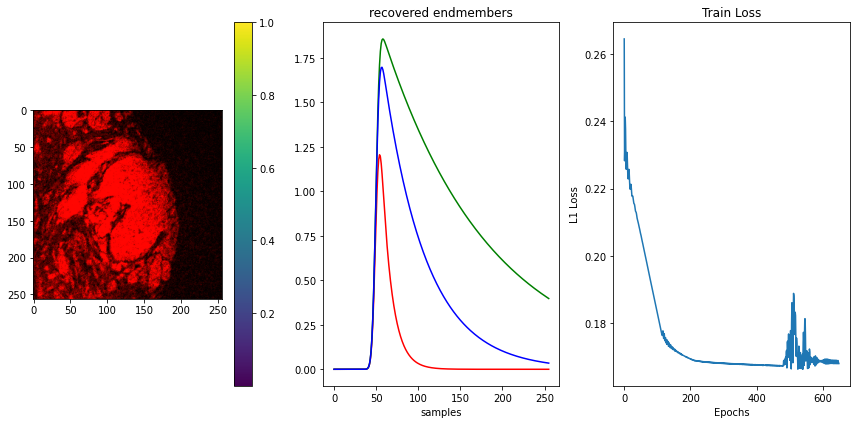

 34%|█████████████▎                         | 680/2000 [00:06<00:13, 100.67it/s]

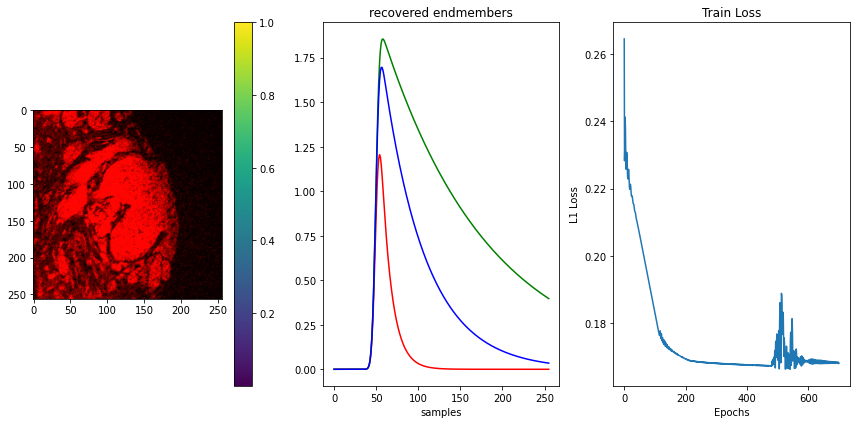

 37%|██████████████▍                        | 742/2000 [00:07<00:10, 119.42it/s]

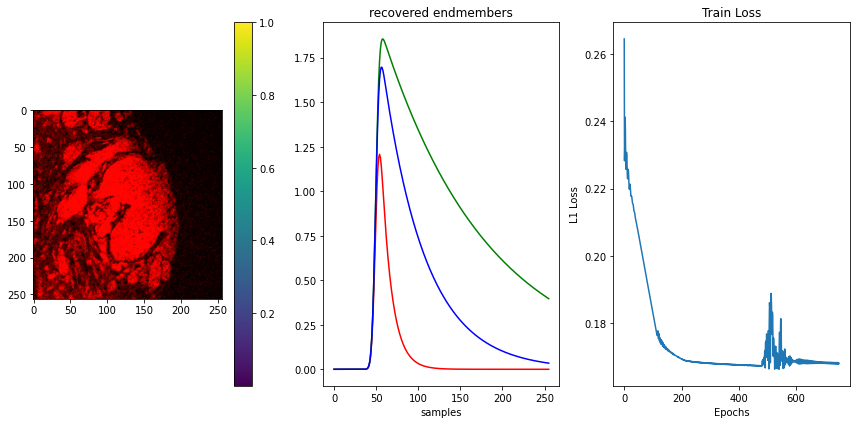

 39%|███████████████▏                       | 780/2000 [00:07<00:11, 107.74it/s]

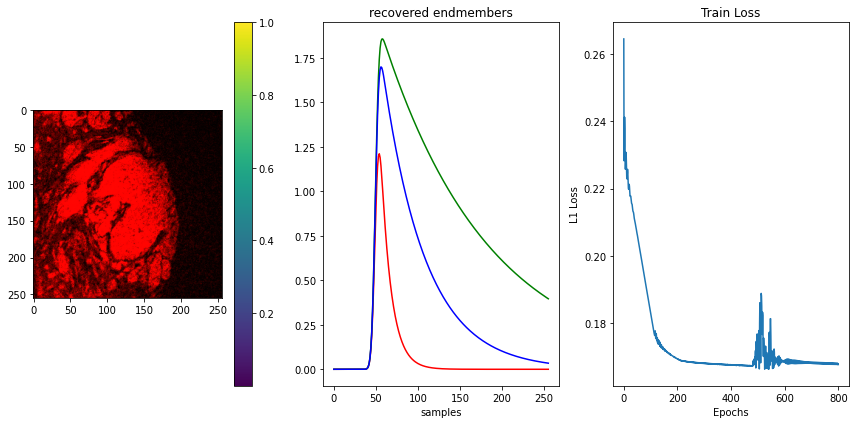

 42%|████████████████▍                      | 841/2000 [00:08<00:09, 121.32it/s]

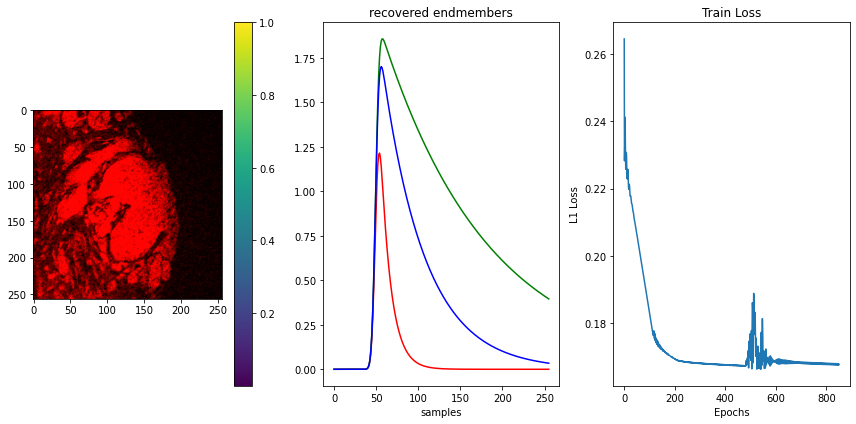

 44%|█████████████████▏                     | 879/2000 [00:08<00:10, 107.75it/s]

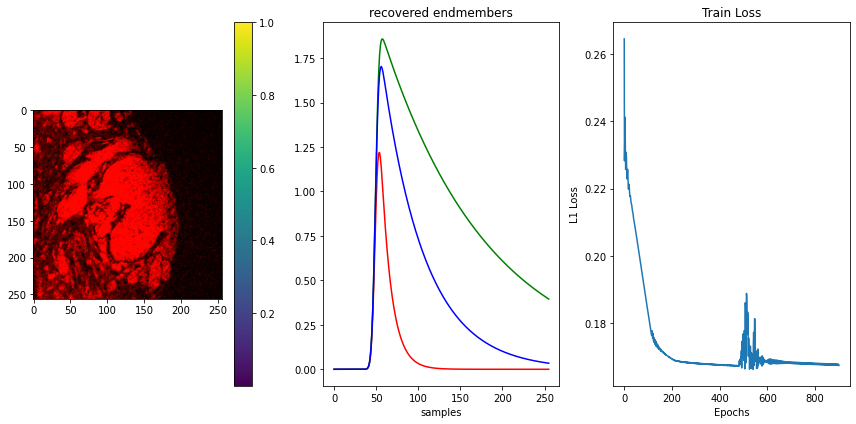

 47%|██████████████████▎                    | 942/2000 [00:09<00:09, 115.62it/s]

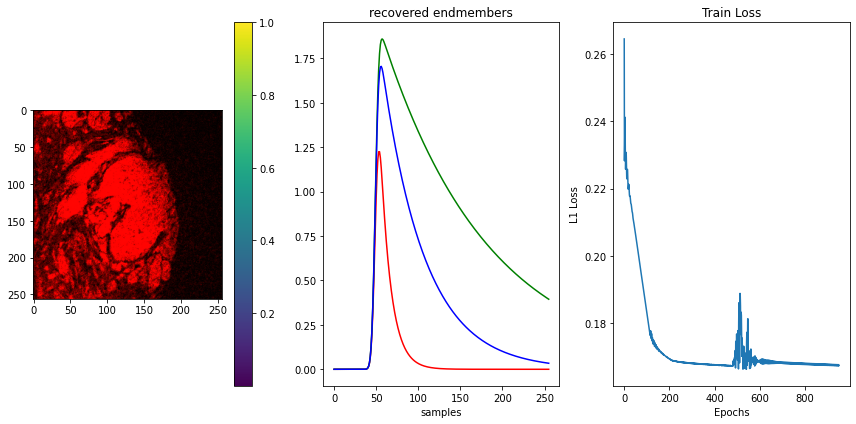

 49%|███████████████████                    | 980/2000 [00:09<00:09, 105.61it/s]

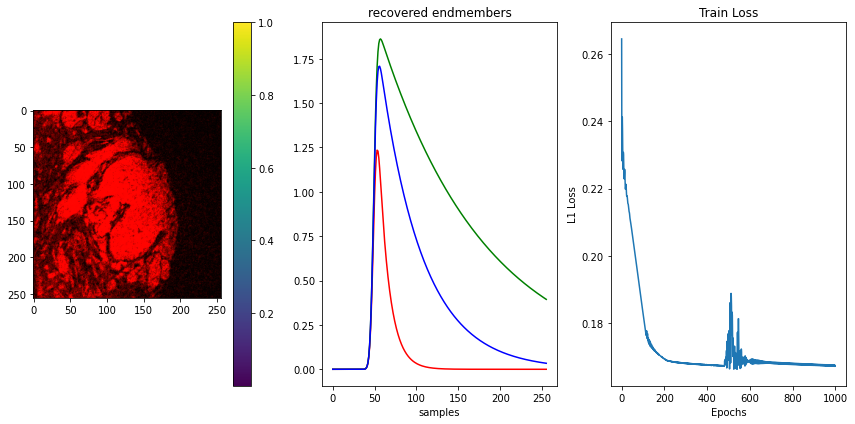

 52%|███████████████████▊                  | 1042/2000 [00:10<00:07, 120.66it/s]

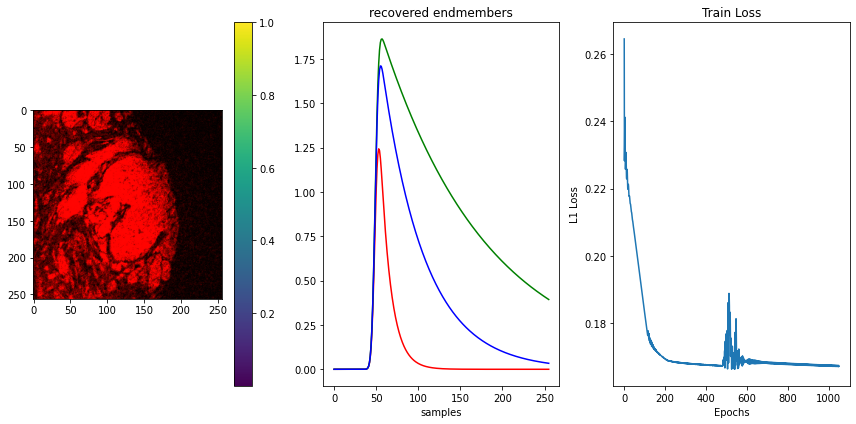

 54%|████████████████████▌                 | 1080/2000 [00:10<00:08, 107.43it/s]

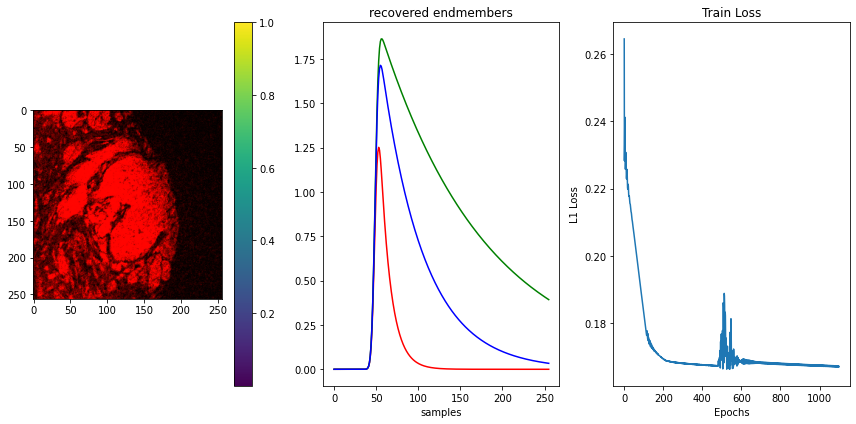

 57%|█████████████████████▋                | 1142/2000 [00:11<00:07, 121.37it/s]

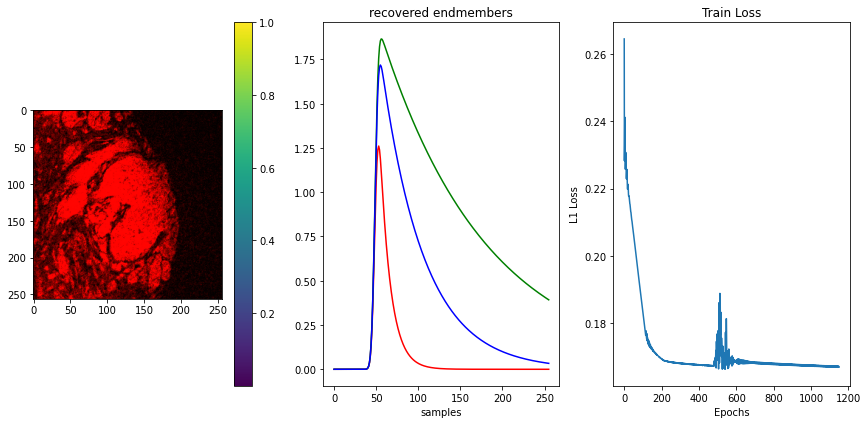

 59%|██████████████████████▍               | 1180/2000 [00:11<00:07, 107.51it/s]

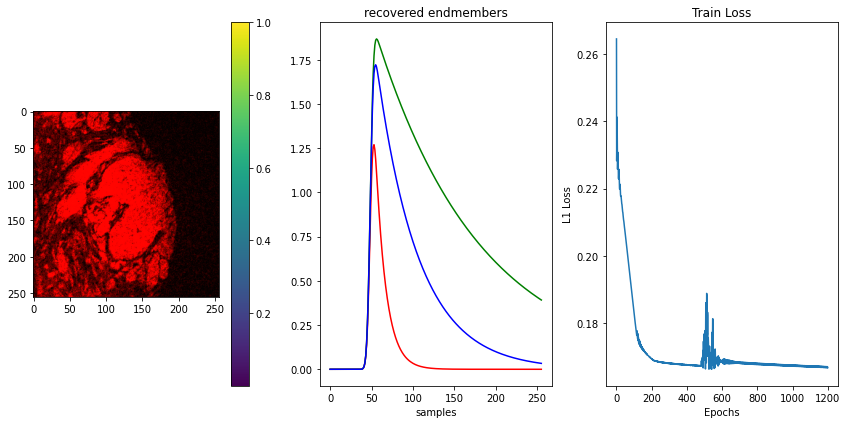

 62%|███████████████████████▌              | 1242/2000 [00:12<00:06, 114.61it/s]

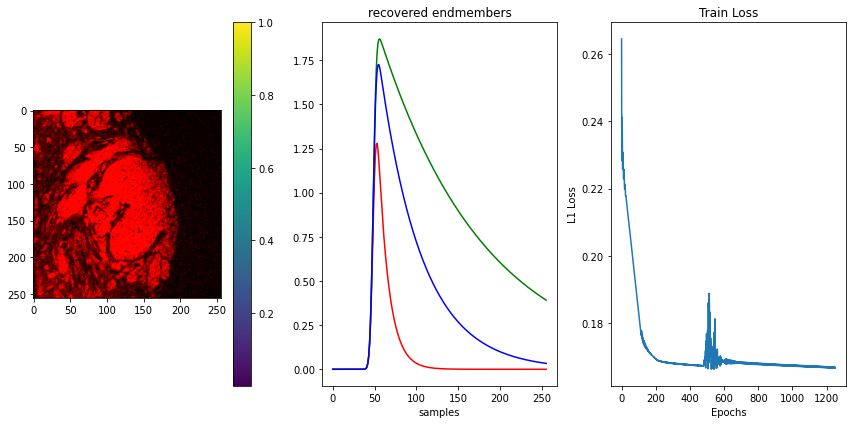

 64%|████████████████████████▎             | 1280/2000 [00:12<00:06, 104.55it/s]

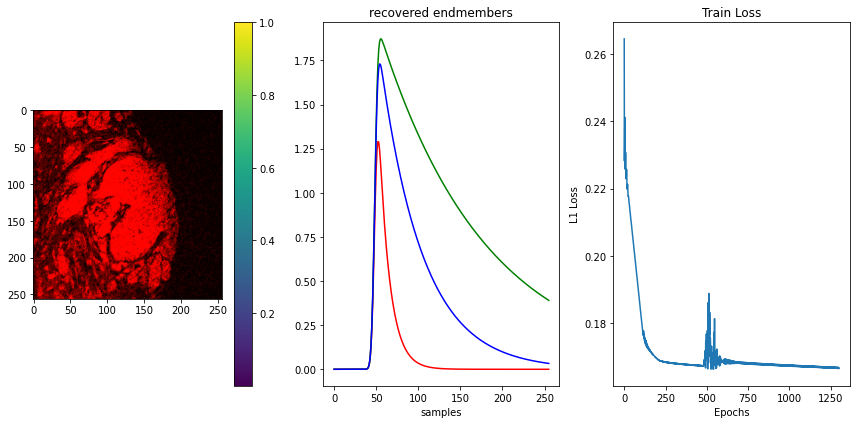

 67%|█████████████████████████▍            | 1342/2000 [00:13<00:05, 120.68it/s]

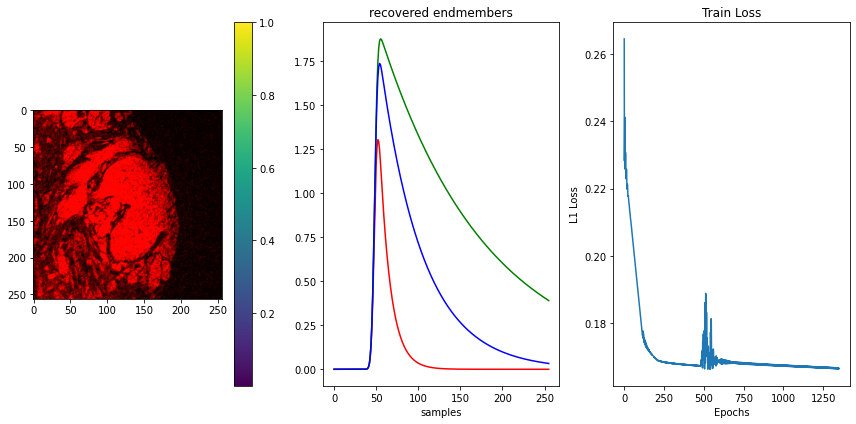

 69%|██████████████████████████▏           | 1380/2000 [00:13<00:05, 107.57it/s]

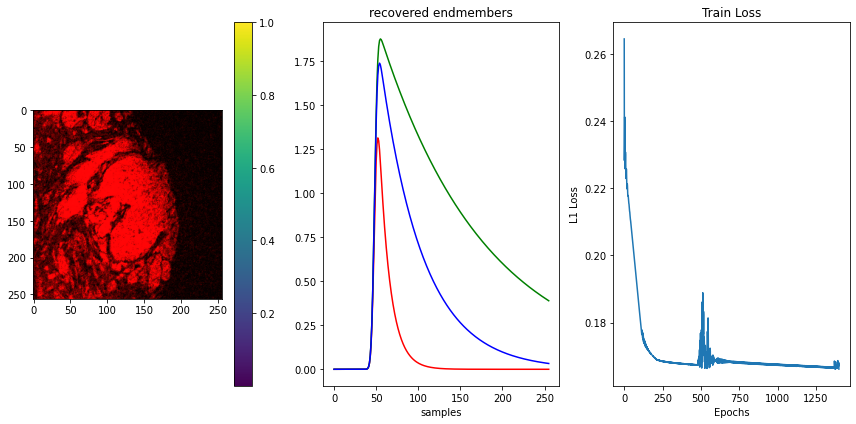

 72%|███████████████████████████▍          | 1442/2000 [00:14<00:04, 121.87it/s]

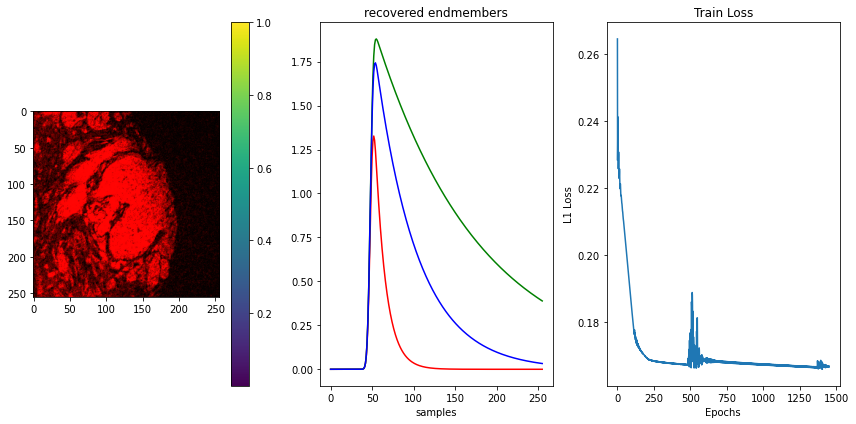

 74%|████████████████████████████          | 1480/2000 [00:15<00:05, 100.07it/s]

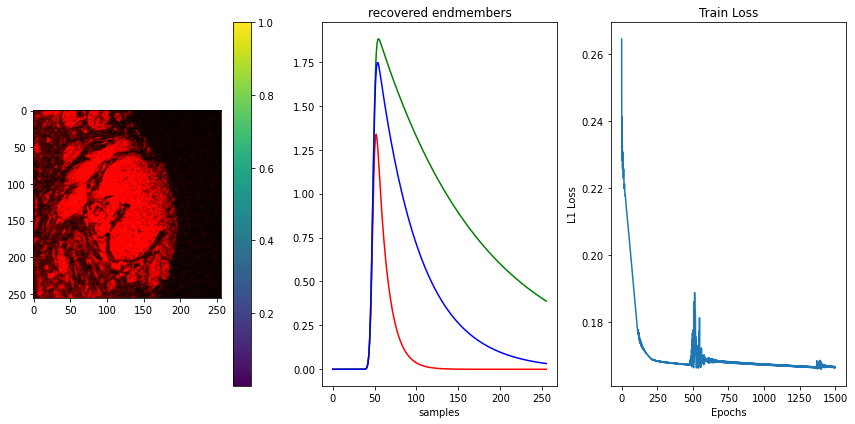

 77%|█████████████████████████████▎        | 1542/2000 [00:15<00:03, 118.13it/s]

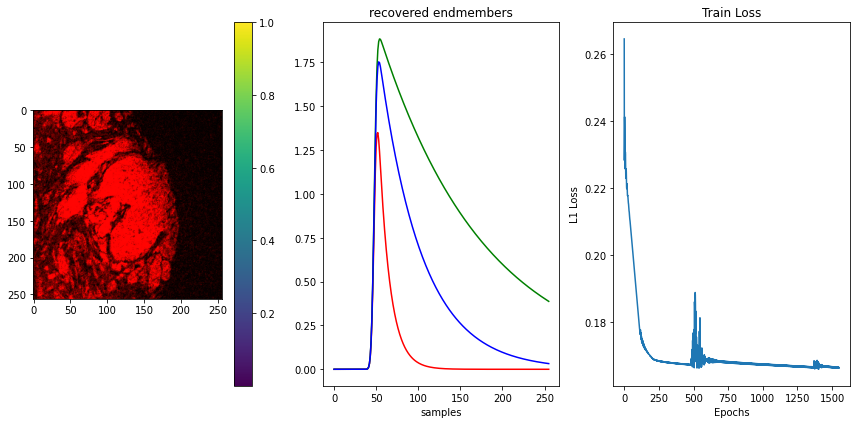

 79%|██████████████████████████████        | 1580/2000 [00:16<00:03, 105.92it/s]

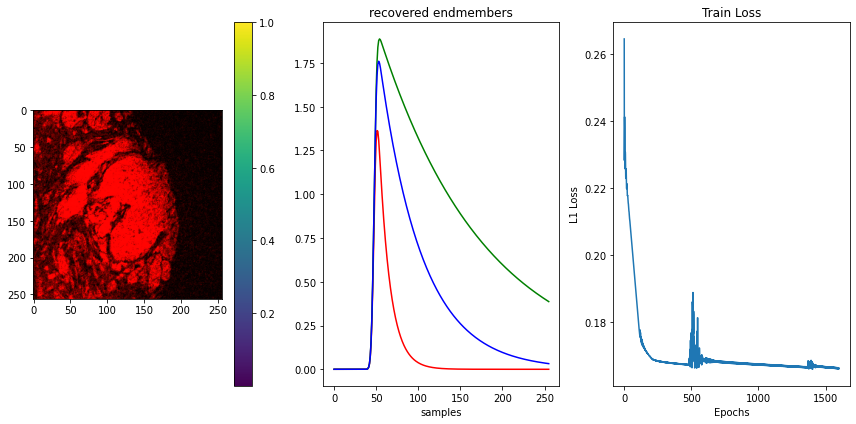

 82%|███████████████████████████████▏      | 1642/2000 [00:16<00:02, 121.15it/s]

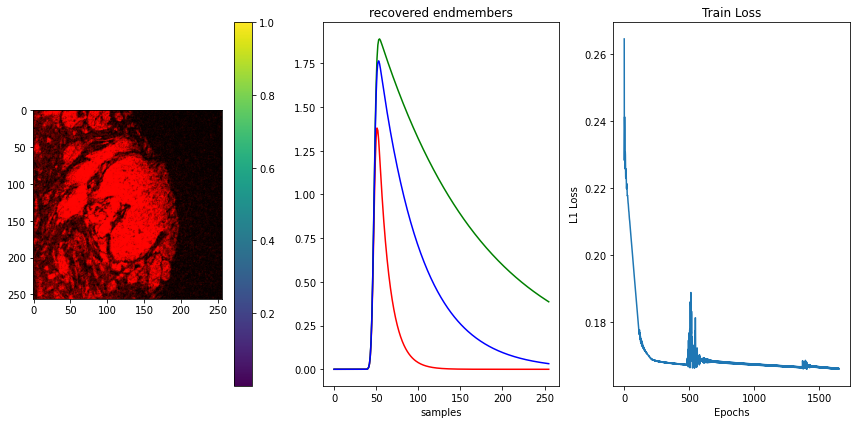

 84%|███████████████████████████████▉      | 1680/2000 [00:17<00:02, 107.83it/s]

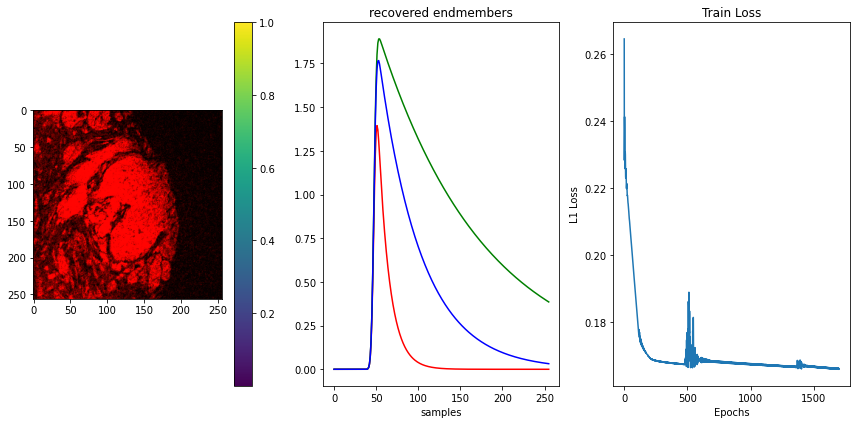

 87%|█████████████████████████████████     | 1742/2000 [00:17<00:02, 122.15it/s]

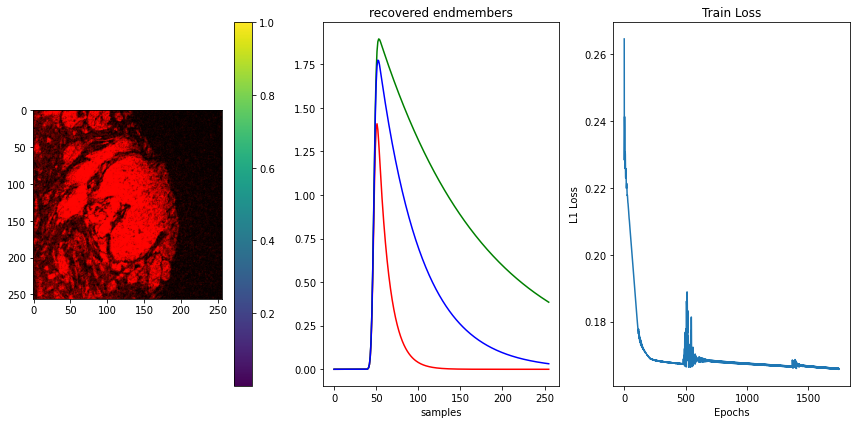

 89%|█████████████████████████████████▊    | 1780/2000 [00:18<00:02, 100.69it/s]

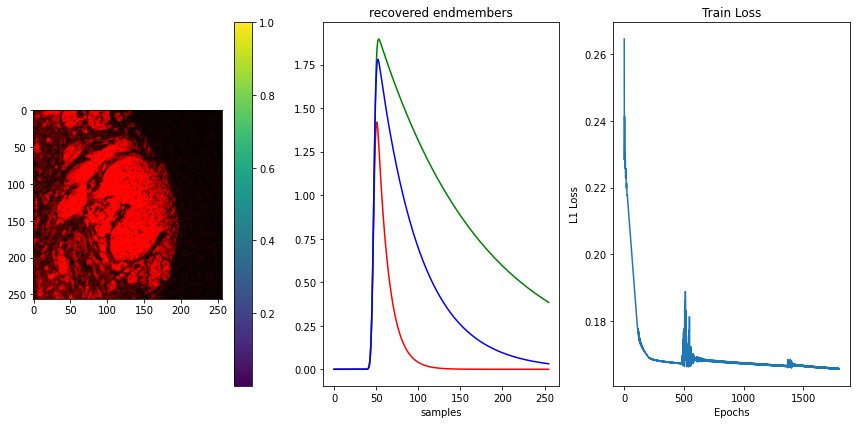

 92%|██████████████████████████████████▉   | 1842/2000 [00:18<00:01, 119.00it/s]

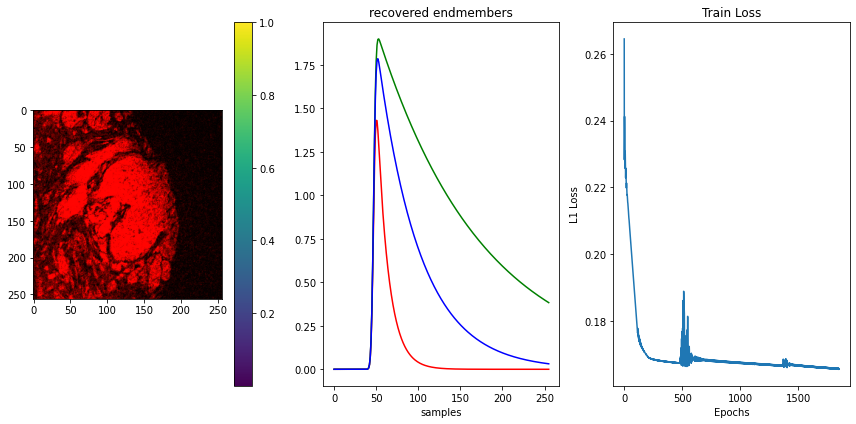

 94%|███████████████████████████████████▋  | 1880/2000 [00:19<00:01, 107.22it/s]

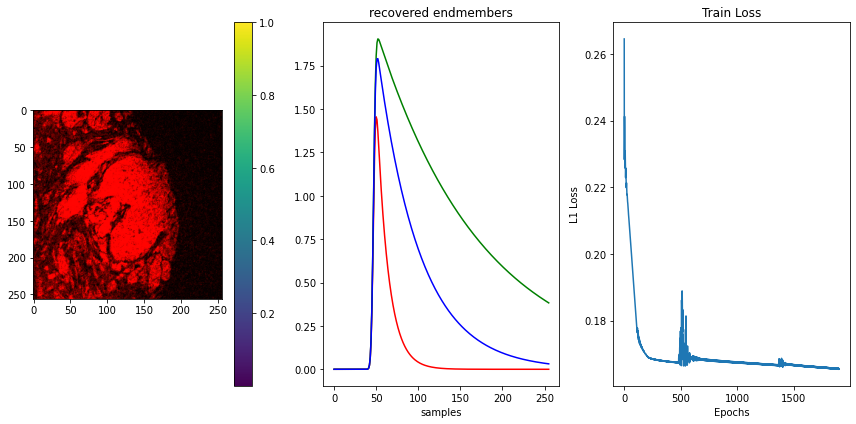

 97%|████████████████████████████████████▉ | 1942/2000 [00:19<00:00, 122.06it/s]

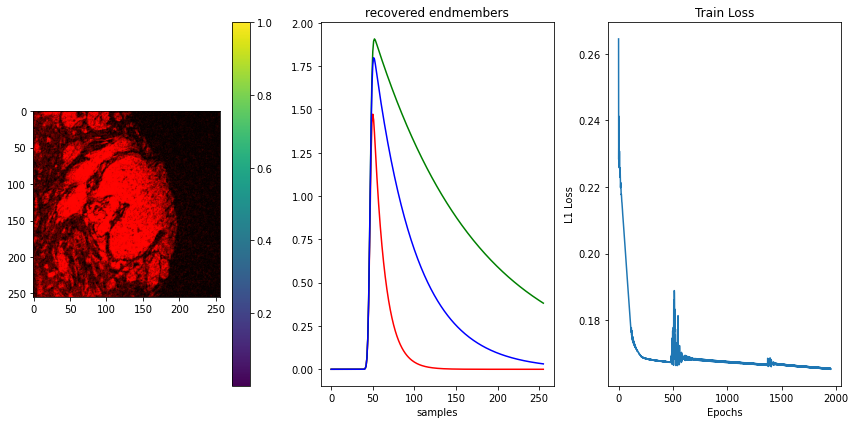

 99%|█████████████████████████████████████▌| 1980/2000 [00:20<00:00, 107.68it/s]

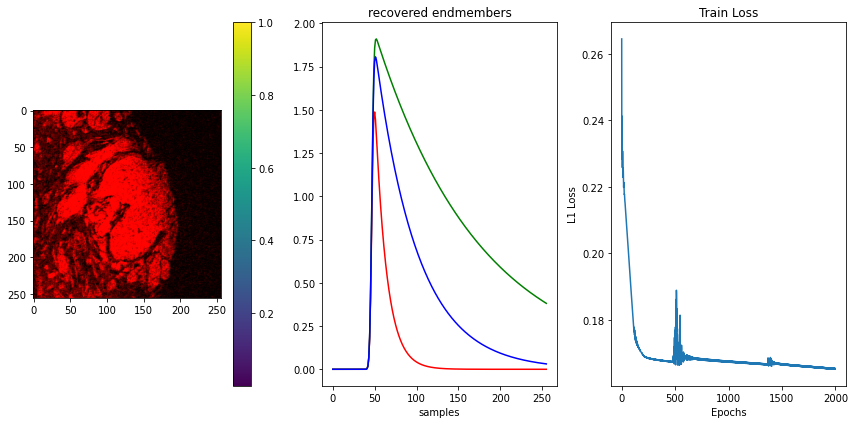

100%|███████████████████████████████████████| 2000/2000 [00:20<00:00, 97.44it/s]

Runs done: 1/1


In [22]:
loss_arr = []

# number of times the experiment is repeated
n_runs = 1
n_epochs = 2000
learning_rate = 1e-4
nch_bottleneck = 3

print('Starting training of models on {}'.format(device))
n_count = 0
for i in range(1,n_runs+1):
    model = Net()
    loss = train_model(model, n_epochs, img_stack, learning_rate)
    loss_arr.append(loss)
    n_count+=1
    print('Runs done: {}/{}'.format(n_count, n_runs))


# Analyze trained models

In [19]:
images = img_stack[None,0]
print(images.shape)
image_x_p = torch.permute(images, (0, 3, 1, 2))
image_x_p = image_x_p.to(device)
z = model.forward_enc(image_x_p)
outputs = model.forward_dec(z)

torch.Size([1, 256, 256, 256])


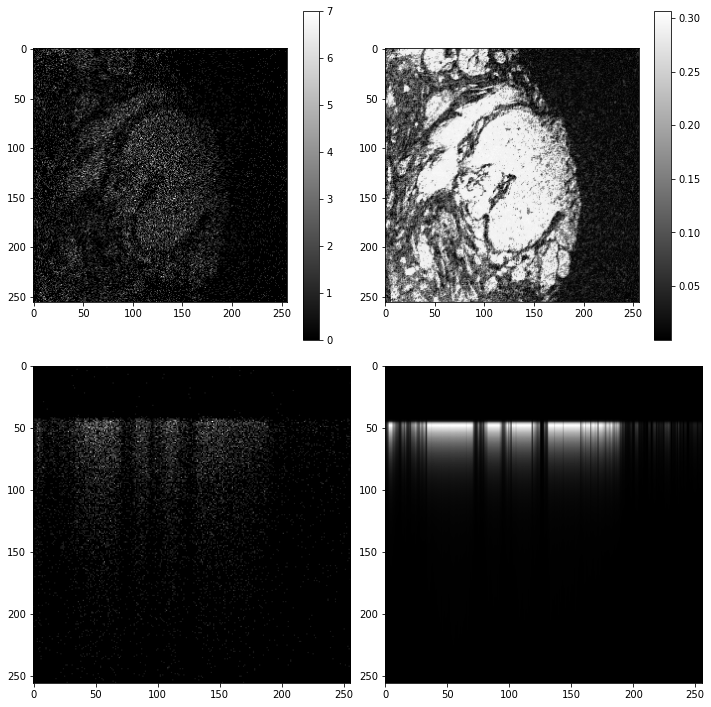

In [20]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(image_x_p[0,70,:,:].detach().cpu().numpy(), cmap='gray')
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(outputs[0,70,:,:].detach().cpu().numpy(), cmap='gray')
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(image_x_p[0,:,128,:].detach().cpu().numpy(), cmap='gray')
plt.subplot(2,2,4)
plt.imshow(outputs[0,:,128,:].detach().cpu().numpy(), cmap='gray')
plt.tight_layout()
plt.show()

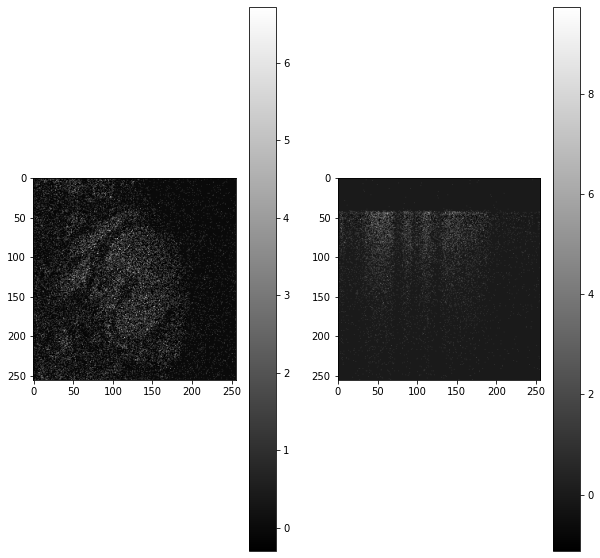

In [24]:
err_stack = image_x_p - outputs
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(err_stack[0,70,:,:].detach().cpu().numpy(), cmap='gray')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(err_stack[0,:,128,:].detach().cpu().numpy(), cmap='gray')
plt.colorbar()
plt.show()

In [10]:
model.sigma

Parameter containing:
tensor([0.2932], device='cuda:1', requires_grad=True)

In [9]:
for par in model.parameters():
    print(par)

Parameter containing:
tensor([1.9353], device='cuda:1', requires_grad=True)
Parameter containing:
tensor([0.2932], device='cuda:1', requires_grad=True)
Parameter containing:
tensor([[0.4019, 1.9542, 4.9068]], device='cuda:1', requires_grad=True)
Parameter containing:
tensor([5.9385], device='cuda:1', requires_grad=True)
Parameter containing:
tensor([[[[-9.5137e-03,  4.9397e-03, -1.9715e-02],
          [-1.2762e-02,  3.6778e-03, -7.7465e-03],
          [-1.8137e-02,  1.3292e-02, -5.0877e-03]],

         [[-2.0882e-02, -1.7692e-02,  5.3685e-03],
          [-5.2731e-03, -2.5559e-03,  3.1336e-06],
          [-1.2887e-02, -4.4478e-03,  3.6917e-03]],

         [[ 9.6950e-03,  9.1821e-03, -1.7185e-03],
          [-2.0868e-02, -1.4483e-02, -6.5021e-03],
          [-1.5605e-02, -9.6865e-03, -2.5941e-03]],

         ...,

         [[ 1.0207e-03, -2.0295e-02, -1.4852e-02],
          [-1.5831e-03, -2.8188e-03, -1.7408e-02],
          [-1.2702e-02,  1.1548e-02, -1.7619e-02]],

         [[ 6.7060e-0

# Experiment with new features

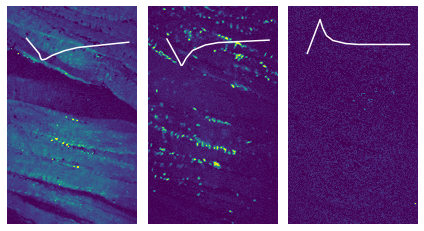

In [203]:
tau=np.array([-2,0,0.2,0.4,1,2,4,6,14])
plt.figure(figsize=(6,9))
for iz in range(nch_bottleneck):
    plt.subplot(1,3,iz+1)
    plt.imshow(z[0,indices[iz],:,:].squeeze().detach().cpu().numpy())
    plt.plot(20*tau+100,100+100*w[:,indices[iz]].squeeze().detach().cpu().numpy(),'w')
    plt.axis(False)
plt.tight_layout()    
plt.show()


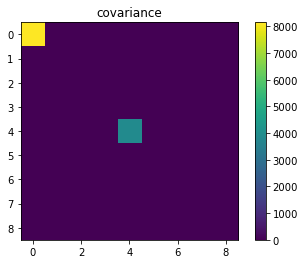

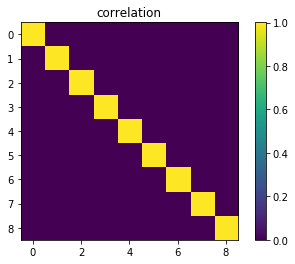

tensor(9.0034, device='cuda:1', grad_fn=<SumBackward0>)

In [113]:
z.squeeze().shape
zvec = z.squeeze().view(9,-1)

covmtrx = torch.matmul(zvec,zvec.transpose(0,1))
plt.imshow(covmtrx.detach().cpu().numpy())
plt.colorbar()
plt.title('covariance')
plt.show()

zvec.size(1)
stds = torch.sqrt(covmtrx.diag()).expand(1,-1)
stdprods= torch.matmul(stds.transpose(0,1),stds)
corrmtrx = covmtrx / stdprods
plt.imshow(corrmtrx.detach().cpu().numpy())
plt.colorbar()
plt.title('correlation')
plt.show()

torch.sum(corrmtrx.triu())

In [1493]:
loss_zcorr

tensor(0.0001, device='cuda:1', grad_fn=<DivBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


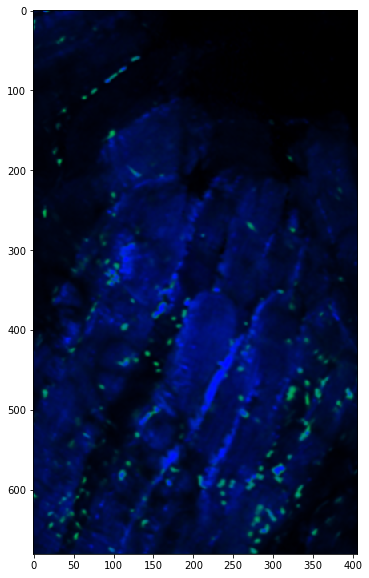

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


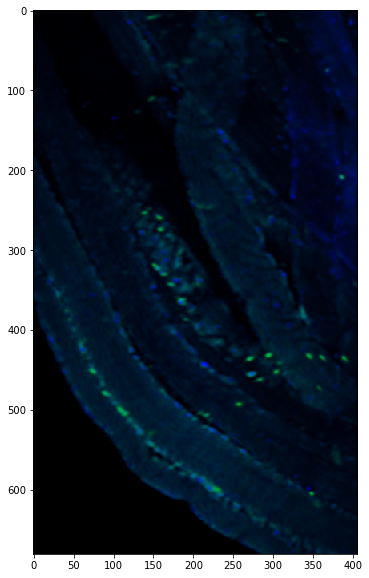

In [1143]:
img = visualize_z(0)
img = visualize_z(1)

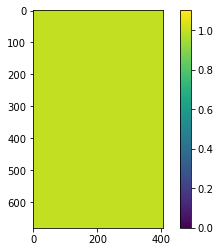

In [51]:
# test
images = img_stack[1]
images = images[None, :]
image_x_p = torch.permute(images, (0, 3, 1, 2))
image_x_p = image_x_p.to(device)
optimizer.zero_grad()         
#outputs = model(image_x_p)
z = model.forward_enc(image_x_p)

z.shape

zsum = torch.sum(z,1)

plt.imshow( zsum.detach().cpu().numpy().squeeze(),vmin=0., vmax=1.1 )
plt.colorbar()
plt.show()

In [15]:
z_imgs = np.asarray(z_imgs)
print(z_imgs.shape)

(4, 681, 406, 3)


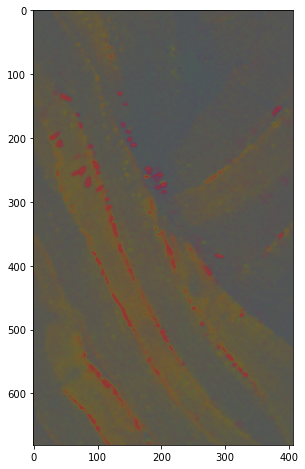

In [24]:
plt.figure(figsize=(8,8))
plt.imshow(z_imgs[2,:,:,:])
plt.show()